In [6]:
from rbbm_src.labelling_func_src.src.lfs_tree import keyword_labelling_func_builder
from rbbm_src.labelling_func_src.src.TreeRules import SPAM, HAM
from rbbm_src.labelling_func_src.src.LFRepair import run_snorkel
from rbbm_src.labelling_func_src.src.classes import clean_text
import re
import pandas as pd
import psycopg2
import pandas as pd
from snorkel.labeling import (
	LabelingFunction, 
	labeling_function, 
	PandasLFApplier, 
	LFAnalysis,
	filter_unlabeled_dataframe
	)
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from rbbm_src.labelling_func_src.src.example_tree_rules import gen_amazon_funcs

In [2]:
kwords_and_label_re = re.compile('\((.*)\)->(\w+)')
mapping_dict = {'negative':SPAM, 'positive':HAM}

In [3]:
def calculate_coverage(df, lf_column):
    total_instances = len(df)
    labeled_instances = df[lf_column] != -1
    coverage = labeled_instances.sum() / total_instances
    return coverage

def calculate_accuracy(df, lf_column, ground_truth_column):
    labeled_instances = df[df[lf_column] != -1]
    correct_labels = (labeled_instances[lf_column] == labeled_instances[ground_truth_column]).sum()
    total_labeled = len(labeled_instances)
    if total_labeled == 0:
        return 0.0  # Avoid division by zero if no instances are labeled
    accuracy = correct_labels / total_labeled
    return accuracy

In [4]:
conn = psycopg2.connect(dbname='label', user='postgres')
sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)
sentences_df = sentences_df.rename(columns={"class": "expected_label", "content": "old_text"})
sentences_df['text'] = sentences_df['old_text'].apply(lambda s: clean_text(s))
sentences_df = sentences_df[~sentences_df['text'].isna()]

/tmp/ipykernel_28724/1980757067.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)


In [5]:
from collections import defaultdict
individual_func_stats = defaultdict(dict)

In [7]:
rules_written = ['(love,terrific,amazing)->positive',
                 '(great,helpful,five stars)->positive',
                 '(repeat customer)->positive',
                 '(beautiful, excellent)->positive',
                 '(favorite,nice)->positive',
                 '(comfortable)->positive',
                 '(one star, terrible)->negative',
                 '(broken, poor)->negative',
                 '(cheap, only)->negative'
                 '(crap,big,small)->negative',
                 '(difficult)->negative',
                 '(not, depress)->negative',
                 '(boring)->negative'
                 ]
manual_tree_rules = []

for r in rules_written:
    try:
        kword_string, label_text = kwords_and_label_re.search(r).groups()
        kwords = [x.strip() for x in kword_string.split(',')]
        label = mapping_dict[label_text.strip()]
        manual_tree_rules.append(keyword_labelling_func_builder(keywords=kwords, expected_label=label))
    except:
        print(f'not captured properly for rule {r}')
manual_funcs = [f.gen_label_rule() for f in manual_tree_rules]

for f in manual_funcs:
    print(f)
    sentences_df['lf_labeled'] = sentences_df.apply(f, axis=1)
    cov=calculate_coverage(df=sentences_df, lf_column='lf_labeled')
    acc=calculate_accuracy(df=sentences_df, lf_column='lf_labeled', ground_truth_column='expected_label')
    individual_func_stats[f]={'cov':cov, 'acc':acc}
    print(f"cov:{round(cov,4)}, acc:{round(acc,4)}")
    print('---------------------------------------\n')

PredicateNode(id=1, pred=keyword_predicate-word-(love,terrific,amazing))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.1854, acc:0.8075
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(great,helpful,five stars))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.3081, acc:0.8674
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(repeat customer))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.0001, acc:0.5
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(beautiful,excellent))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.0515, acc:0.856
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(favorite,nice))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.0752, acc:0.7812
---------------------------------------

PredicateNode(id=1, pred=keyword_pred

In [8]:
amazon_treerules = gen_amazon_funcs()
amazon_funcs = [f.gen_label_rule() for f in amazon_treerules]

In [9]:
total_funcs = []
total_funcs.extend(amazon_funcs)
total_funcs.extend(manual_funcs)

In [10]:
len(total_funcs)

27

In [11]:
applier = PandasLFApplier(lfs=total_funcs)
initial_vectors = applier.apply(df=sentences_df, progress_bar=False)
model = LabelModel(cardinality=2, verbose=True, device='cpu')
model.fit(L_train=initial_vectors, n_epochs=500, log_freq=100, seed=123)

probs_test= model.predict_proba(L=initial_vectors)

INFO 2024-08-05 03:33:39,439 [label_model.py:fit:905] Computing O...
INFO 2024-08-05 03:33:39,454 [label_model.py:fit:911] Estimating \mu...
100%|████████████████████████████████████████████████████| 500/500 [00:00<00:00, 891.89epoch/s]
INFO 2024-08-05 03:33:40,020 [label_model.py:fit:977] Finished Training


In [12]:
df_sentences_filtered, probs_test_filtered, filtered_vectors, df_no_signal = filter_unlabeled_dataframe(
        X=sentences_df, y=probs_test, L=initial_vectors
)

df_sentences_filtered = df_sentences_filtered.reset_index(drop=True)
prob_diffs = [abs(t[0]-t[1]) for t in probs_test_filtered]
prob_diffs_tuples = [(t[0],t[1]) for t in probs_test_filtered]
df_sentences_filtered['model_pred_diff'] = pd.Series(prob_diffs)
df_sentences_filtered['model_pred_prob_tuple'] = pd.Series(prob_diffs_tuples)
df_sentences_filtered['model_pred'] = pd.Series(model.predict(L=filtered_vectors))

wrong_preds = df_sentences_filtered[(df_sentences_filtered['expected_label']!=df_sentences_filtered['model_pred'])]

accuracy=(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)

print(f"""
    out of {len(sentences_df)} sentences, {len(df_sentences_filtered)} actually got at least one signal to \n
    make prediction. Out of all the valid predictions, we have {len(wrong_preds)} wrong predictions, \n
    accuracy = {(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)} 
    """)


    out of 19946 sentences, 19328 actually got at least one signal to 

    make prediction. Out of all the valid predictions, we have 3842 wrong predictions, 

    accuracy = 0.8012210264900662 
    


In [80]:
(19328-3842)/19946

0.7763962699288078

In [13]:
analysis = LFAnalysis(L=initial_vectors, lfs=total_funcs)
analysis.lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
"PredicateNode(id=1, pred=keyword_predicate-word-(star,stars))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",0,[0],0.282463,0.280758,0.204502
"PredicateNode(id=1, pred=keyword_predicate-word-(product,fit,quality,size,cheap,wear))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",1,[1],0.290635,0.286524,0.209766
"PredicateNode(id=1, pred=keyword_predicate-word-(great))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",2,[0],0.206457,0.206457,0.168455
"PredicateNode(id=1, pred=keyword_predicate-word-(great))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(stars,works))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=0)",3,[0],0.055149,0.055149,0.040710
"PredicateNode(id=1, pred=keyword_predicate-word-(waste))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",4,[1],0.049283,0.048631,0.021508
"PredicateNode(id=1, pred=keyword_predicate-word-(shoes,item,price,comfortable,plastic))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",5,[0],0.138775,0.137521,0.126040
"PredicateNode(id=1, pred=keyword_predicate-word-(junk,bought,like,dont,just,use,buy,work,small,didnt,did,disappointed))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",6,[1],0.626090,0.590344,0.404743
"PredicateNode(id=0, pred=keyword_predicate-word-(junk,bought,like,dont,just,use,buy,work,small,didnt,did,disappointed))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(shoes,metal,fabric,replace,battery,warranty,plug))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=1)",7,[1],0.069287,0.069287,0.051840
"PredicateNode(id=1, pred=keyword_predicate-word-(love,perfect,loved,nice,excellent,works,loves,awesome,easy))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",8,[0],0.349042,0.345834,0.284318
"PredicateNode(id=1, pred=keyword_predicate-word-(love,perfect,loved,nice,excellent,works,loves,awesome,easy))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(stars,soft))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=0)",9,[0],0.071794,0.071794,0.043066


In [82]:
lf_vectors = filtered_vectors
ground_truth = df_sentences_filtered['expected_label']
snorkel_predictions = df_sentences_filtered['model_pred']
snorkel_probs = df_sentences_filtered['model_pred_diff']

In [42]:
snorkel_predictions.shape

(19328,)

In [43]:
ground_truth.shape

(19328,)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Define the abstain label
abstain_label = -1


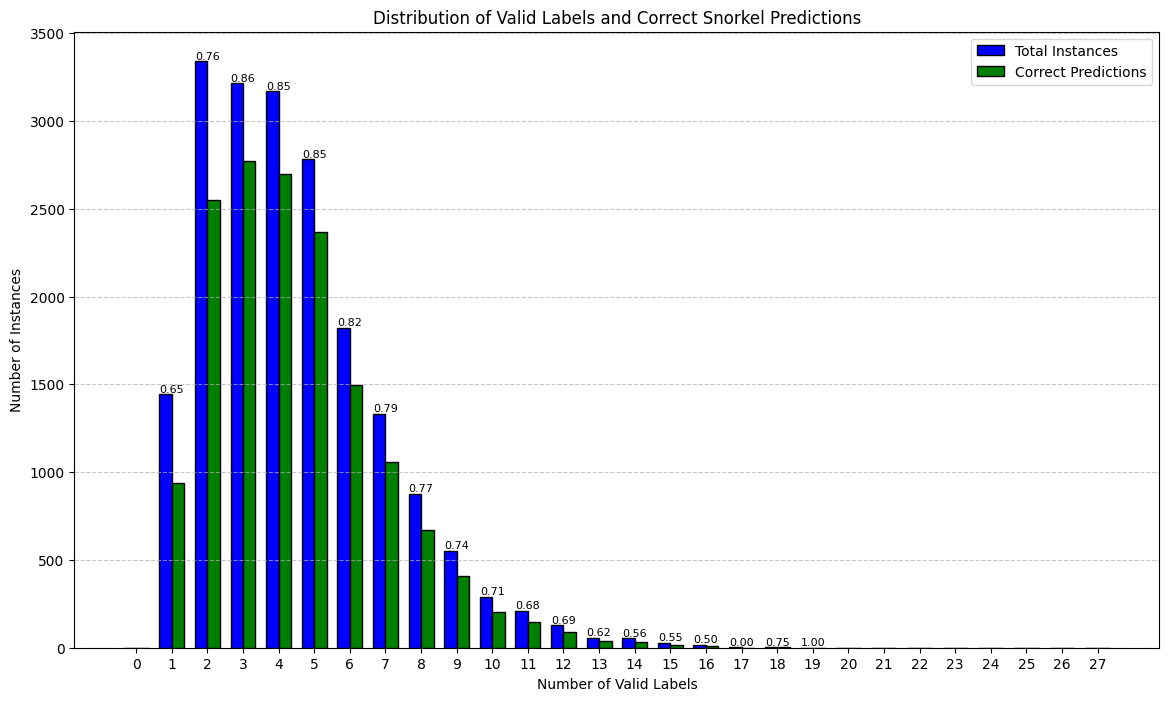

In [52]:
# Count the number of valid (non-abstain) labels for each instance
valid_label_counts = np.sum(lf_vectors != abstain_label, axis=1)

# Determine the number of correct Snorkel predictions
correct_predictions = (snorkel_predictions == ground_truth)

# Count the total instances and correct predictions for each number of valid labels
max_valid_labels = 27
total_counts = Counter(valid_label_counts)
correct_counts = Counter(valid_label_counts[correct_predictions])

# Prepare data for plotting
x = np.arange(max_valid_labels + 1)
total_instances = np.array([total_counts[i] for i in x])
correct_instances = np.array([correct_counts[i] for i in x])

# Calculate the ratio for annotations
ratios = np.divide(correct_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)


# Plot the grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.35

plt.bar(x - bar_width / 2, total_instances, bar_width, label='Total Instances', color='blue', edgecolor='black')
plt.bar(x + bar_width / 2, correct_instances, bar_width, label='Correct Predictions', color='green', edgecolor='black')

plt.xlabel('Number of Valid Labels')
plt.ylabel('Number of Instances')
plt.title('Distribution of Valid Labels and Correct Snorkel Predictions')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(len(x)):
    if total_instances[i] > 0:  # Only add text if there are instances
        plt.text(x[i], total_instances[i] + 0.5, f'{ratios[i]:.2f}', ha='center', va='bottom', fontsize=8)


plt.show()


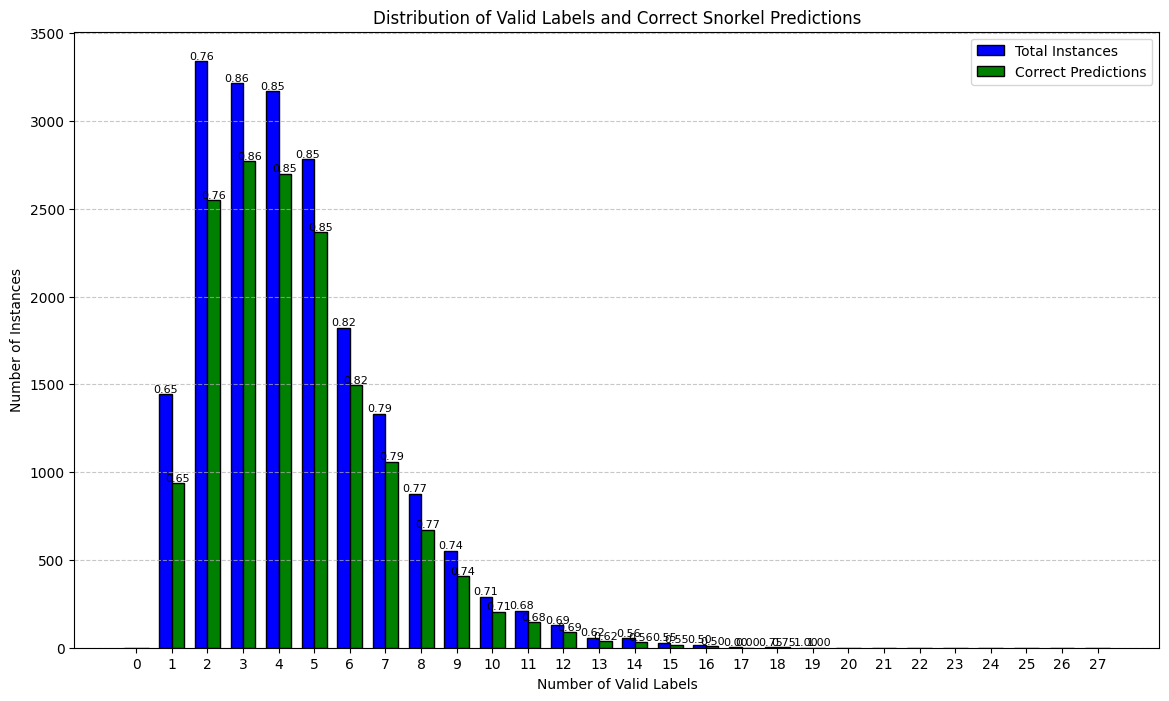

In [54]:


# Define the abstain label
abstain_label = -1

# Count the number of valid (non-abstain) labels for each instance
valid_label_counts = np.sum(lf_vectors != abstain_label, axis=1)

# Determine the number of correct Snorkel predictions
correct_predictions = (snorkel_predictions == ground_truth)

# Count the total instances and correct predictions for each number of valid labels
max_valid_labels = 27
total_counts = Counter(valid_label_counts)
correct_counts = Counter(valid_label_counts[correct_predictions])

# Prepare data for plotting
x = np.arange(max_valid_labels + 1)
total_instances = np.array([total_counts[i] for i in x])
correct_instances = np.array([correct_counts[i] for i in x])

# Calculate the ratio for tooltips
ratios = np.divide(correct_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances!=0)

# Plot the grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.35

total_bars = plt.bar(x - bar_width / 2, total_instances, bar_width, label='Total Instances', color='blue', edgecolor='black')
correct_bars = plt.bar(x + bar_width / 2, correct_instances, bar_width, label='Correct Predictions', color='green', edgecolor='black')

plt.xlabel('Number of Valid Labels')
plt.ylabel('Number of Instances')
plt.title('Distribution of Valid Labels and Correct Snorkel Predictions')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations for the ratios
for i in range(len(x)):
    if total_instances[i] > 0:  # Only add text if there are instances
        plt.text(x[i] - bar_width / 2, total_instances[i] + 0.5, f'{ratios[i]:.2f}', ha='center', va='bottom', fontsize=8)
        plt.text(x[i] + bar_width / 2, correct_instances[i] + 0.5, f'{ratios[i]:.2f}', ha='center', va='bottom', fontsize=8)


plt.show()


DEBUG 2024-08-05 10:32:05,259 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:05,259 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:32:05,270 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:05,271 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG 2024-

DEBUG 2024-08-05 10:32:05,634 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:32:05,737 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:05,738 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:32:05,739 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:05,740 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04,

DEBUG 2024-08-05 10:32:06,008 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:06,009 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:32:06,014 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:06,015 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:32:06,017 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:06,017 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e

DEBUG 2024-08-05 10:32:06,180 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:06,182 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:32:06,227 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:06,228 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-05 10:32:06,230 [ticker.py:tick_values:2375] vmin 0.6665092425832341 vmax 5012.683675699776
DEBUG 2024-08-05 10:32:06,231 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e

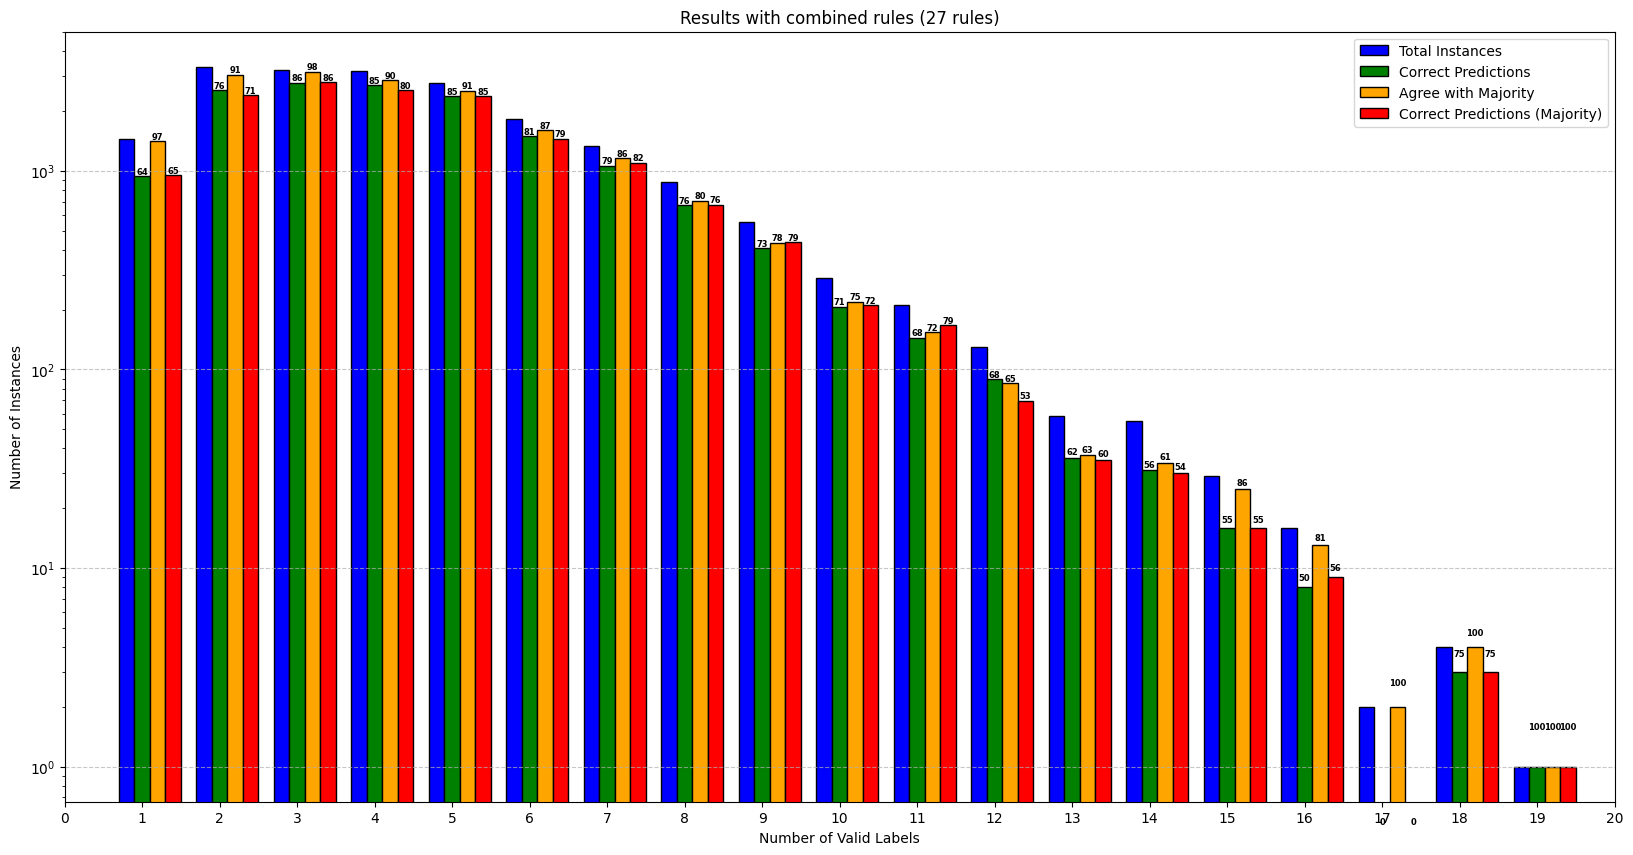

In [75]:

from collections import Counter


# Define the abstain label
abstain_label = -1

# Calculate the majority vote for each instance
def majority_vote(labels):
    valid_labels = [label for label in labels if label != abstain_label]
    if valid_labels:
        return Counter(valid_labels).most_common(1)[0][0]
    else:
        return abstain_label

majority_votes = np.array([majority_vote(row) for row in lf_vectors])

# Count the number of valid (non-abstain) labels for each instance
valid_label_counts = np.sum(lf_vectors != abstain_label, axis=1)

# Determine the number of correct Snorkel predictions
correct_predictions = (snorkel_predictions == ground_truth)

# Determine the number of Snorkel predictions that agree with the majority vote
agree_with_majority = (snorkel_predictions == majority_votes)

# correct majority results
correct_majority_predictions = (majority_votes == ground_truth)

# Count the total instances, correct predictions, and agreements with majority vote for each number of valid labels
max_valid_labels = 27
total_counts = Counter(valid_label_counts)
correct_counts = Counter(valid_label_counts[correct_predictions])
agree_counts = Counter(valid_label_counts[agree_with_majority])
correct_majority_counts = Counter(valid_label_counts[correct_majority_predictions])


# Prepare data for plotting
x = np.arange(max_valid_labels + 1)
total_instances = np.array([total_counts[i] for i in x])
correct_instances = np.array([correct_counts[i] for i in x])
agree_instances = np.array([agree_counts[i] for i in x])
correct_majority_instances = np.array([correct_majority_counts[i] for i in x])


# Calculate the ratio for annotations
ratios_correct = np.divide(correct_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_agree = np.divide(agree_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_correct_majority = np.divide(correct_majority_instances, total_instances, out=np.zeros_like(correct_majority_instances, dtype=float), where=total_instances != 0)


plt.figure(figsize=(20, 10))
bar_width = 0.2
total_bars = plt.bar(x - bar_width, total_instances, bar_width, label='Total Instances', color='blue', edgecolor='black')
correct_bars = plt.bar(x, correct_instances, bar_width, label='Correct Predictions', color='green', edgecolor='black')
agree_bars = plt.bar(x + bar_width, agree_instances, bar_width, label='Agree with Majority', color='orange', edgecolor='black')
correct_majority_bars = plt.bar(x + 2 * bar_width, correct_majority_instances, bar_width, label='Correct Predictions (Majority)', color='red', edgecolor='black')


plt.xlabel('Number of Valid Labels')
plt.ylabel('Number of Instances')
plt.title('Results with combined rules (27 rules)')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Limit the x-axis range
plt.xlim(0, 20)  # Adjust the range as needed
# Set y-axis to logarithmic scale
plt.yscale('log')
# Add annotations for the ratios
for i in range(len(x)):
    if total_instances[i] > 0:  # Only add text if there are instances
        plt.text(x[i], correct_instances[i] + 0.5, f'{int(ratios_correct[i]*100)}', ha='center', va='bottom', fontweight='bold', fontsize=6)
        plt.text(x[i] + bar_width, agree_instances[i] + 0.5, f'{int(ratios_agree[i]*100)}', ha='center', va='bottom', fontweight='bold', fontsize=6)
        plt.text(x[i] + 2 * bar_width, correct_majority_instances[i] + 0.5, f'{int(ratios_correct_majority[i]*100)}', ha='center', va='bottom', fontweight='bold', fontsize=6, color='black')
plt.savefig('distribution_of_labels_rules_combined.pdf', format='pdf')

plt.show()


In [76]:
sum([v for v in correct_majority_counts.values()])

15263

In [77]:
len(lf_vectors)

19328

In [78]:
lf_vectors.shape

(19328, 27)

In [79]:
15263/19328

0.7896833609271523

In [81]:
def drill_down_dist(lf_vectors, chosen_valid_labels, snorkel_probs, snorkel_preds):
    # Filter the data for instances with the chosen number of valid labels
    # valid_label_counts = np.sum(initial_vectors != abstain_label, axis=1)
    filtered_indices = np.where(valid_label_counts == chosen_valid_labels)[0]
    # lf_vectors = initial_vectors[filtered_indices]
    lf_vectors_for_chosen_valid_labels = lf_vectors[filtered_indices]
        #  Calculate the number of spam, ham, and abstain labels
    spam_counts = np.sum(lf_vectors_for_chosen_valid_labels == SPAM, axis=1)
    ham_counts = np.sum(lf_vectors_for_chosen_valid_labels == HAM, axis=1)
    abstain_counts = np.sum(lf_vectors_for_chosen_valid_labels == abstain_label, axis=1)

    # Calculate the breakdown for each number of spam labels (x-axis)
    x_vals = np.arange(chosen_valid_labels + 1)

    array = []
    for i in x_vals:
        mask = (spam_counts == i)

        e = [
            np.sum(mask),  # Number of Spam labels
    #         np.sum(ham_counts[mask]),  # Number of Ham labels
    #         np.sum(abstain_counts[mask])  # Number of Abstain labels
        ]

        array.append(e)

    spam_ham_abstain = np.array(array)


    # Calculate the number of correct predictions by Snorkel vs. Ground Truth
    correct_predictions = snorkel_predictions[filtered_indices] == ground_truth[filtered_indices]
    correct_counts = np.array([
        np.sum((spam_counts == i) & correct_predictions) for i in x_vals
    ])

    # Plotting the stacked bar plot for the breakdown
    plt.figure(figsize=(14, 8))

    # Stacked bar plot for spam, ham, and abstain
    plt.bar(x_vals, spam_ham_abstain[:, 0], label='#Spam labe', color='red', width=0.5)
    # plt.bar(x_vals, spam_ham_abstain[:, 1], bottom=spam_ham_abstain[:, 0], label='Ham', color='green')
    # plt.bar(x_vals, spam_ham_abstain[:, 2], bottom=spam_ham_abstain[:, 0] + spam_ham_abstain[:, 1], label='Abstain', color='grey')

    # Bar plot for correct predictions by Snorkel vs. Ground Truth
    plt.bar(x_vals + 0.4, correct_counts, width=0.4, label='Correct Predictions', color='blue')

    plt.xlabel('Number of Spam Labels', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.title(f'Breakdown for {chosen_valid_labels} Valid Labels', fontsize=16)
    plt.xticks(x_vals + 0.2, x_vals)  # Align x-ticks with the center of the grouped bars
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    plt.show()


    plt.figure(figsize=(14, 8))

    boxplot_data = [snorkel_probs[filtered_indices][spam_counts == i] for i in x_vals]
    # print([b.tolist() for b in boxplot_data])
    plt.boxplot(boxplot_data, positions=x_vals, patch_artist=True)
    plt.legend(fontsize=12)

    plt.show()


DEBUG 2024-08-19 04:47:19,114 [font_manager.py:_findfont_cached:1464] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
DEBUG 2024-08-19 04:47:19,115 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG 2024-08-19 04:47:19,115 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG 2024-08-19 04:47:19,116 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/pyt

DEBUG 2024-08-19 04:47:19,133 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
DEBUG 2024-08-19 04:47:19,134 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG 2024-08-19 04:47:19,135 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1

DEBUG 2024-08-19 04:47:19,154 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG 2024-08-19 04:47:19,155 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG 2024-08-19 04:47:19,156 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationMono-Italic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG 2024-08-19 04:47:19,157 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSansNarrow-BoldOblique.otf', name='Nimbus Sans Narr

DEBUG 2024-08-19 04:47:19,178 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Italic.otf', name='P052', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG 2024-08-19 04:47:19,178 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/URWGothic-DemiOblique.otf', name='URW Gothic', style='oblique', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG 2024-08-19 04:47:19,179 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Regular.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG 2024-08-19 04:47:19,180 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationSerif-BoldItalic.ttf', name='Liberation Serif', style='italic', var

DEBUG 2024-08-19 04:47:19,200 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG 2024-08-19 04:47:19,201 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG 2024-08-19 04:47:19,202 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', si

DEBUG 2024-08-19 04:47:19,221 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/home/opc/.pyenv/versions/3.8.0/envs/label/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG 2024-08-19 04:47:19,222 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationSansNarrow-Italic.ttf', name='Liberation Sans Narrow', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG 2024-08-19 04:47:19,222 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG 2024-08-19 04:47:19,223 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fna

DEBUG 2024-08-19 04:47:19,241 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSansNarrow-Bold.otf', name='Nimbus Sans Narrow', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG 2024-08-19 04:47:19,242 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationSerif-Italic.ttf', name='Liberation Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG 2024-08-19 04:47:19,242 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationSans-Bold.ttf', name='Liberation Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG 2024-08-19 04:47:19,243 [font_manager.py:_findfont_cached:1476] findfont: score(FontEntry(fname='/usr/share/fonts/liberation/LiberationSansNarrow-BoldItalic.ttf', name

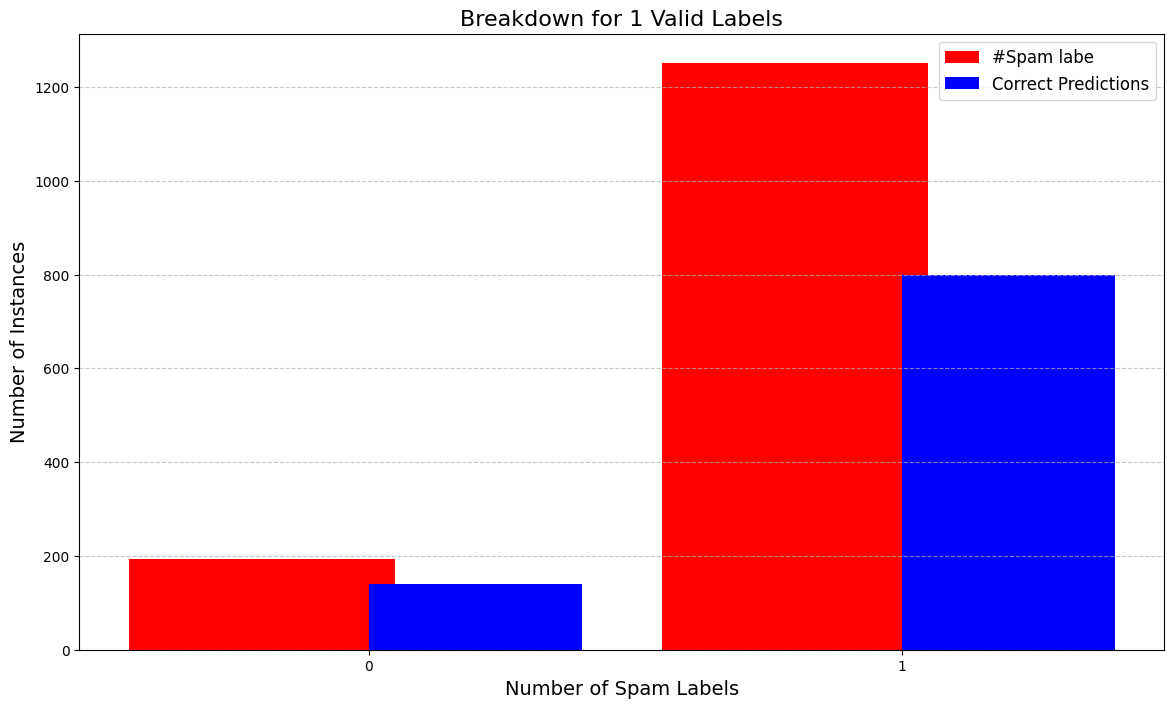

WARNING 2024-08-19 04:47:19,417 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


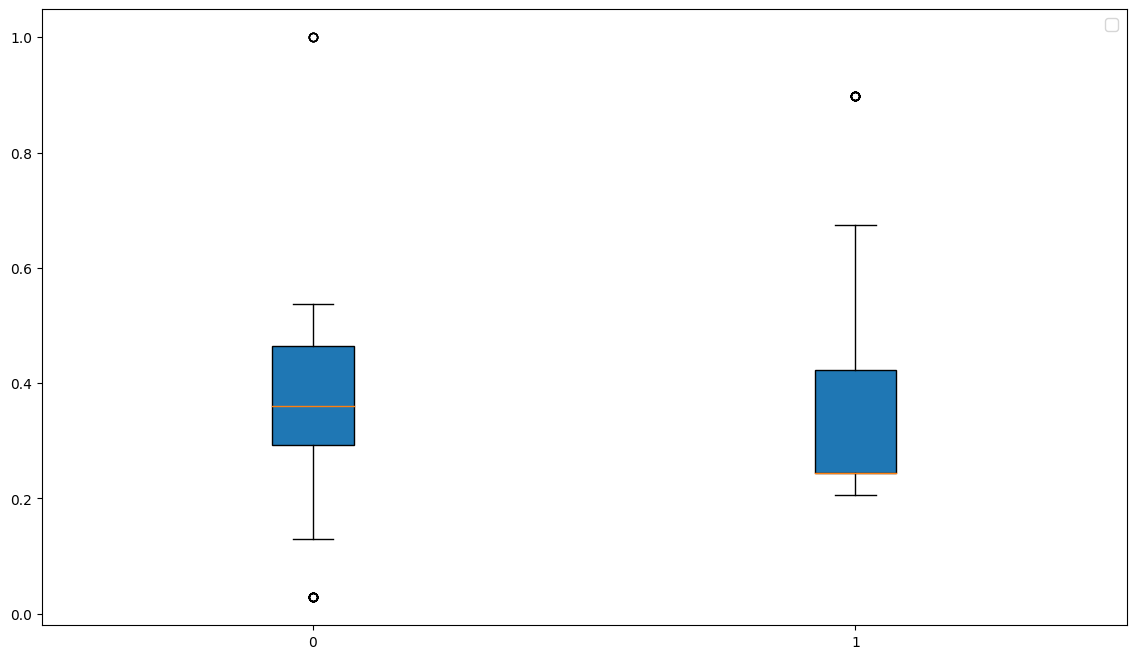

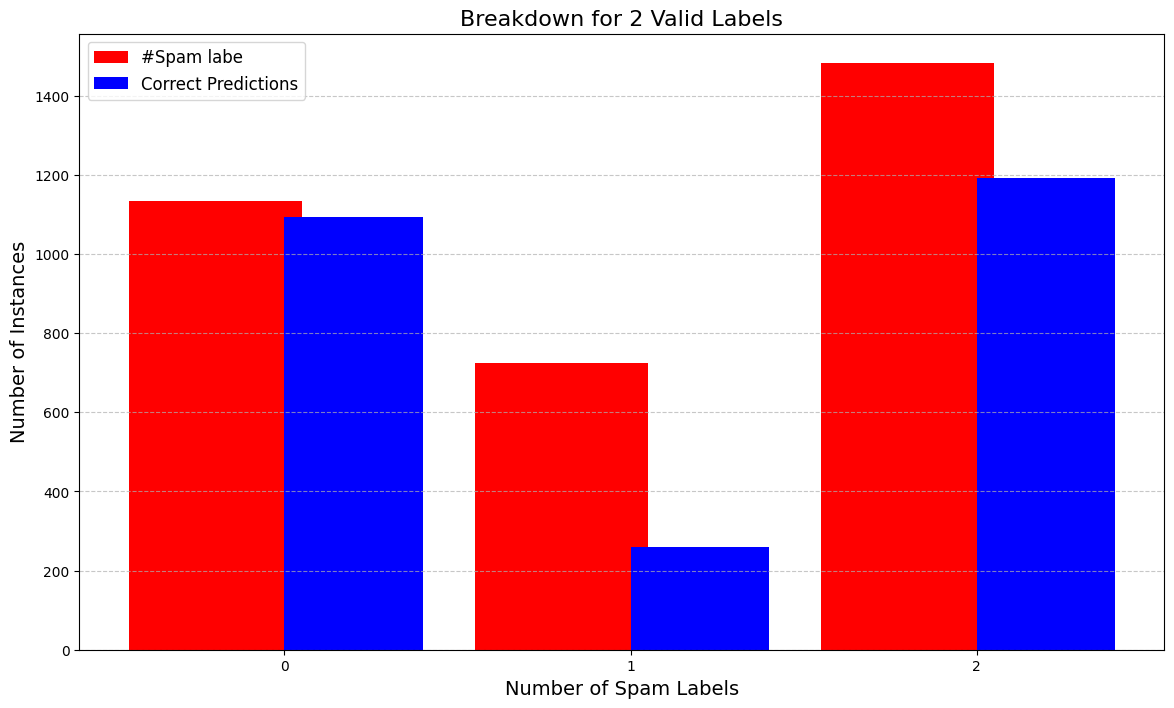

WARNING 2024-08-19 04:47:19,732 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


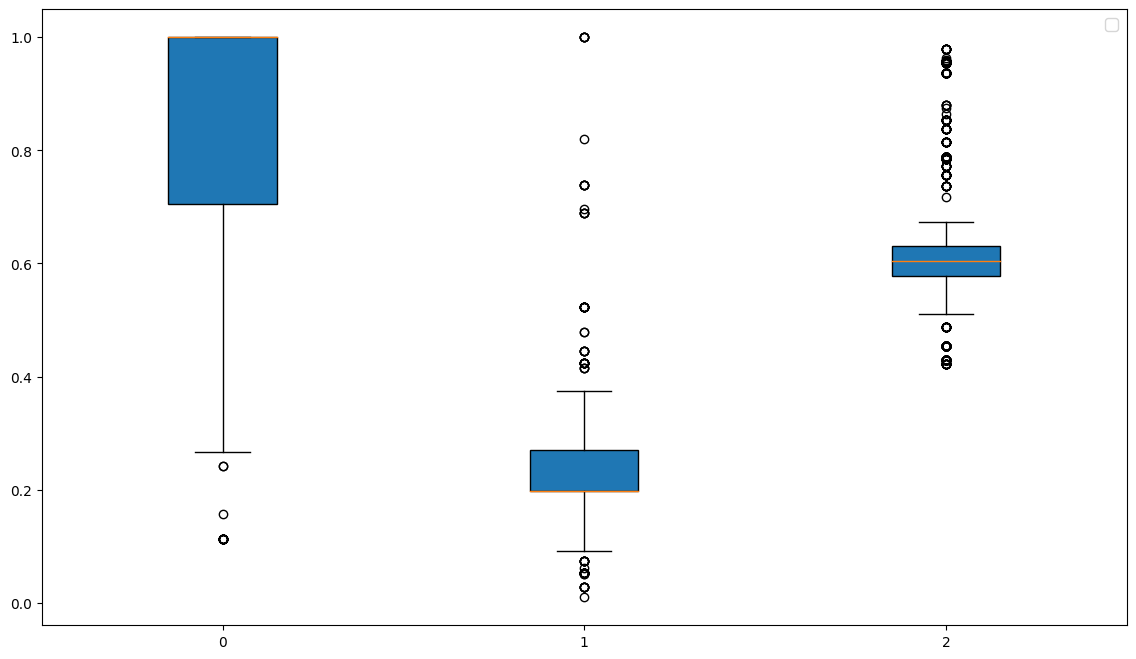

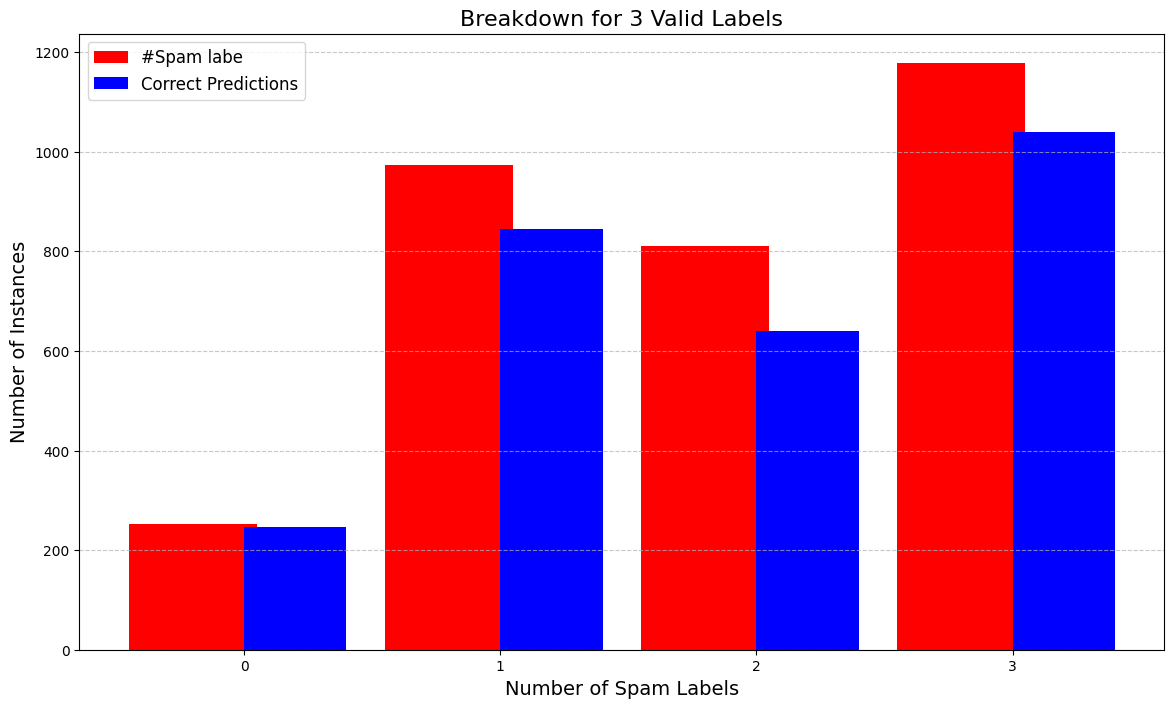

WARNING 2024-08-19 04:47:20,068 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


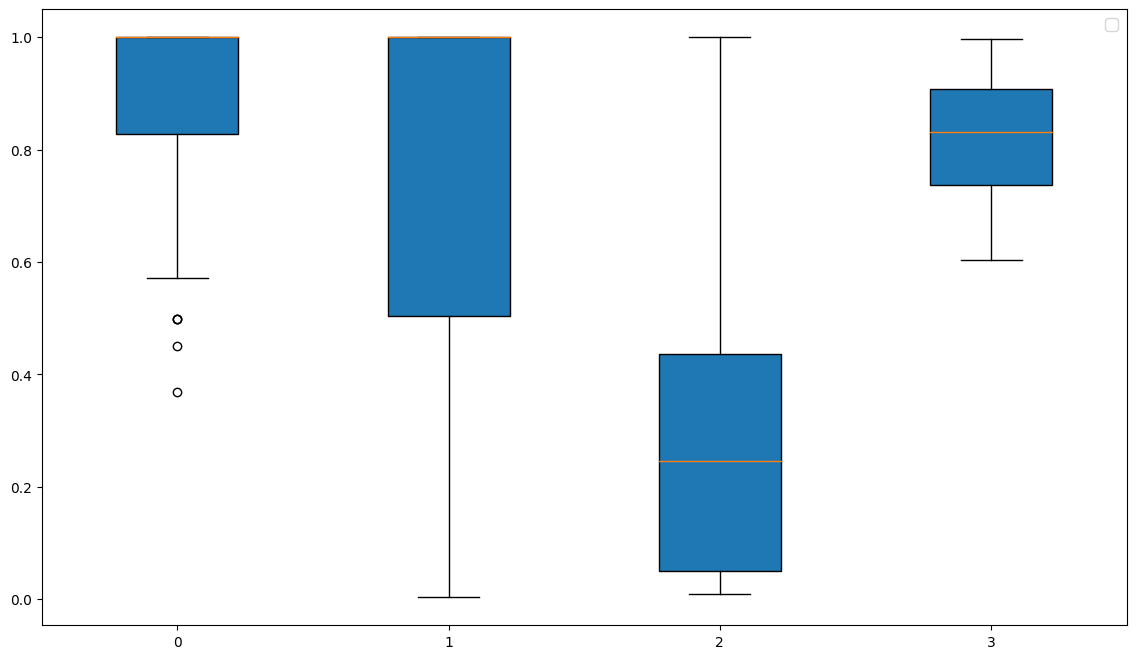

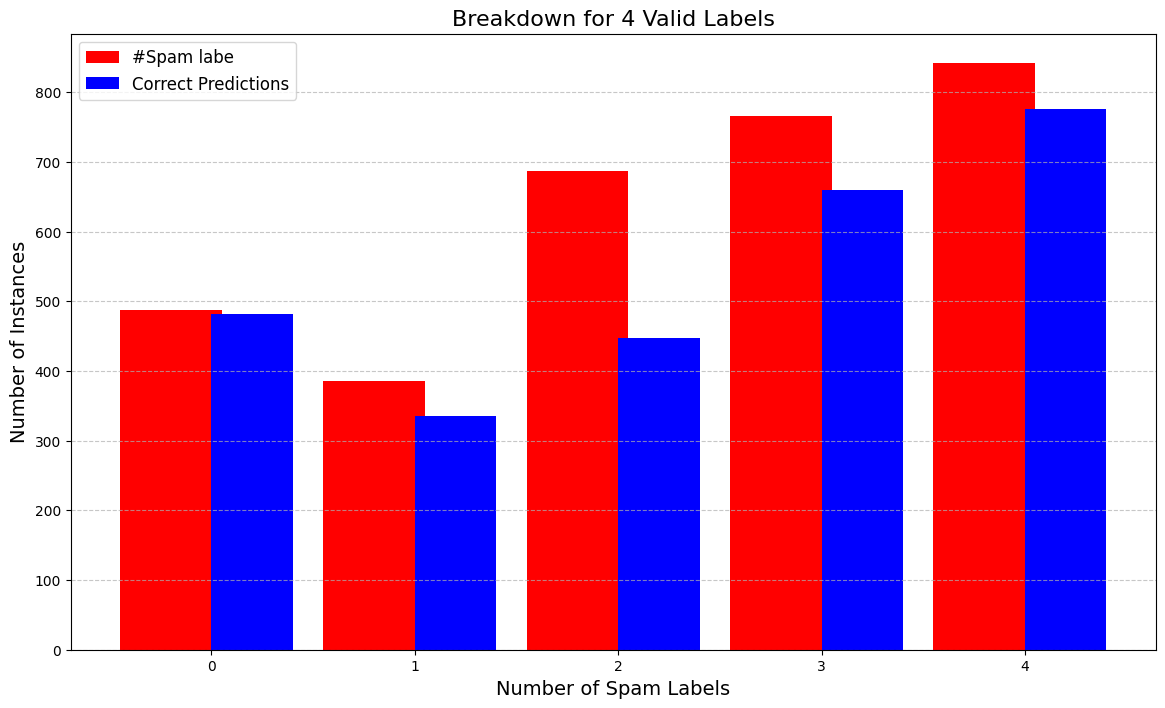

WARNING 2024-08-19 04:47:20,422 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


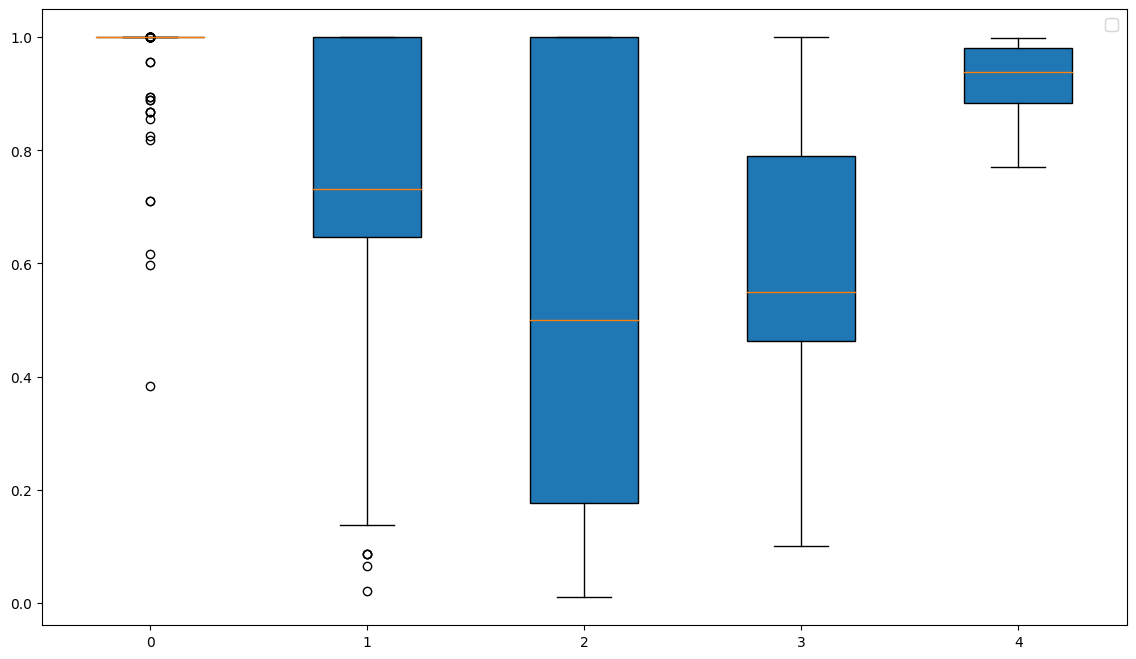

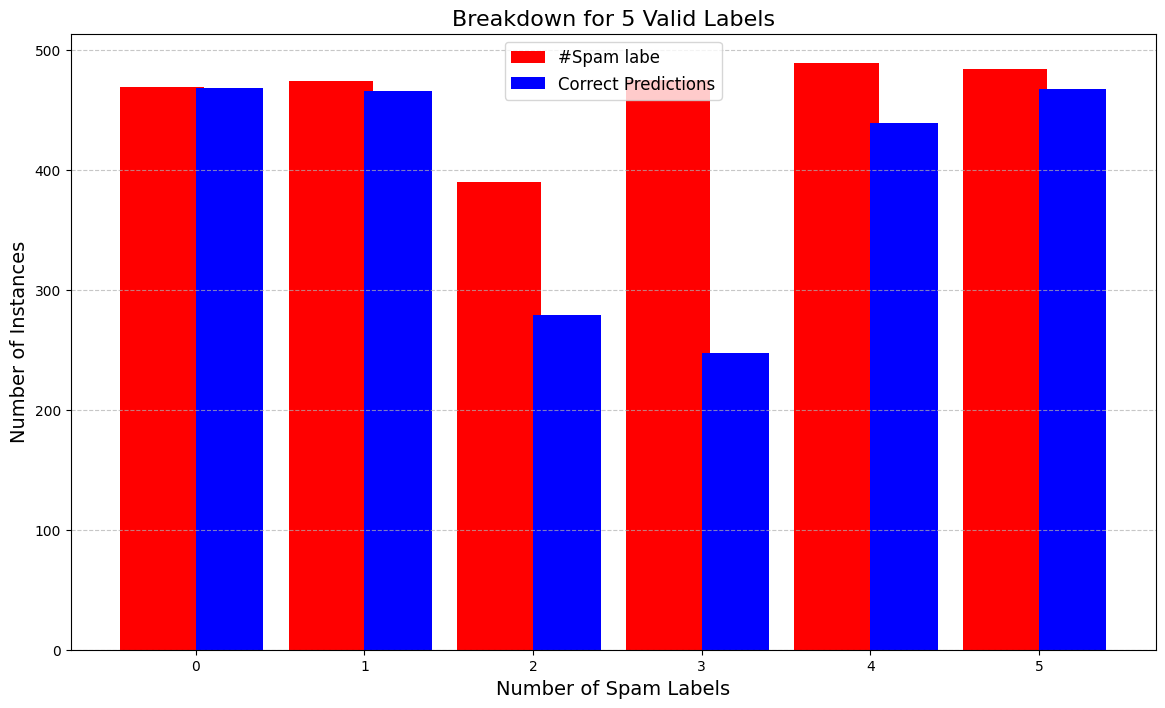

WARNING 2024-08-19 04:47:20,784 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


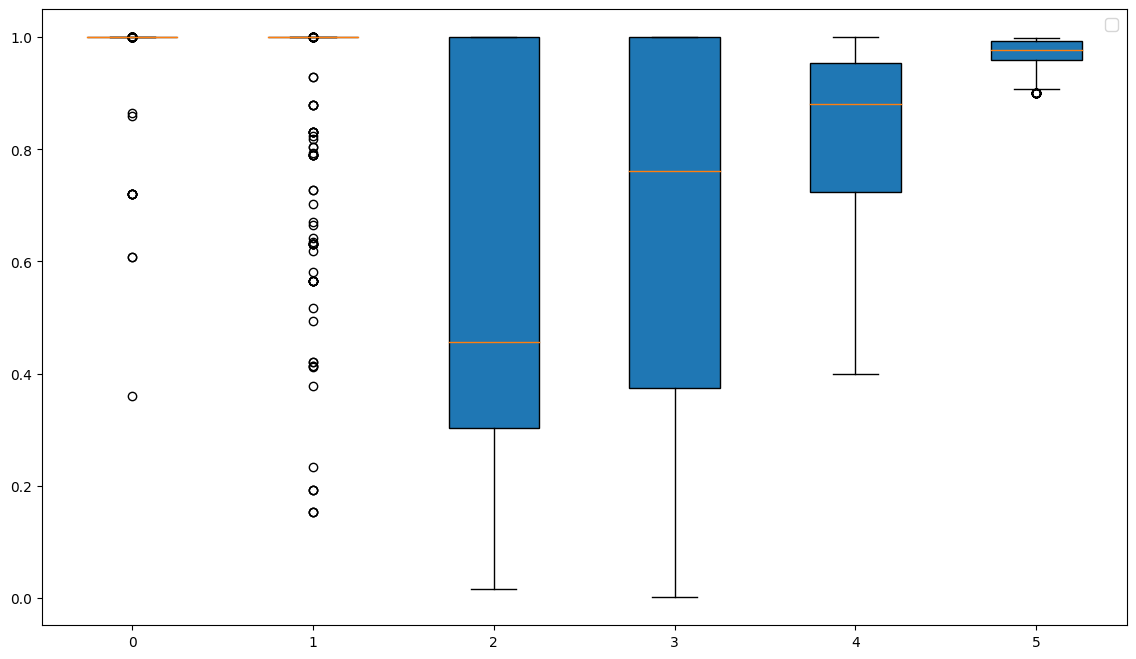

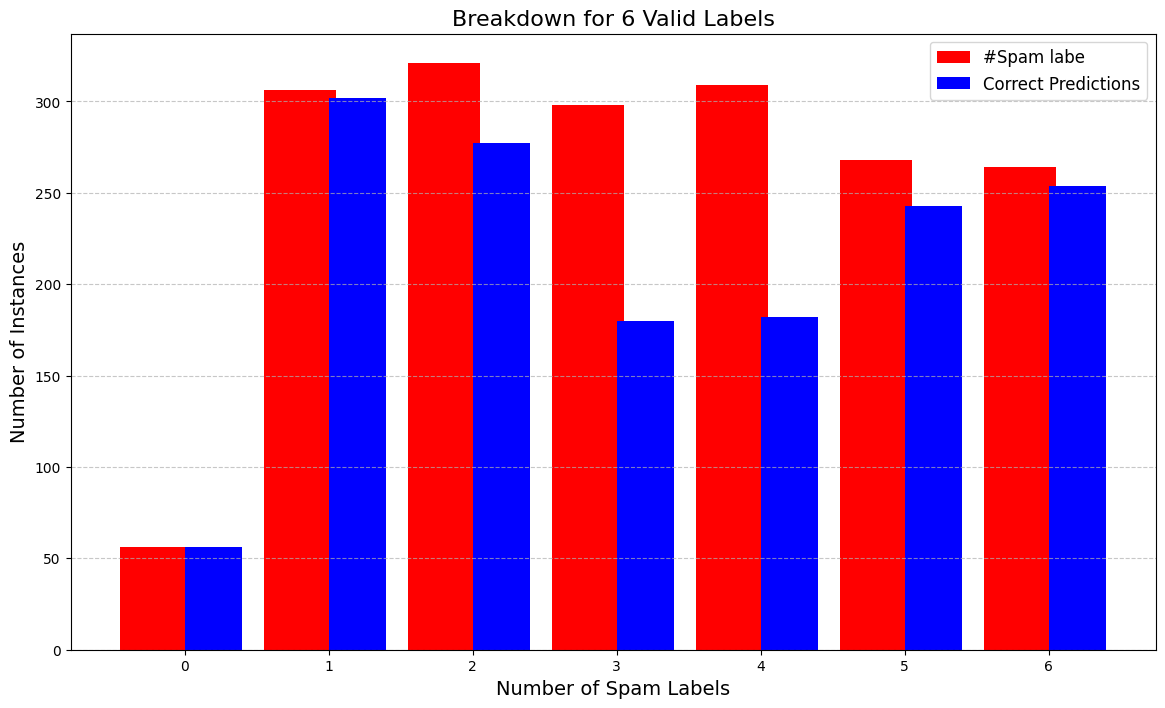

WARNING 2024-08-19 04:47:21,173 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


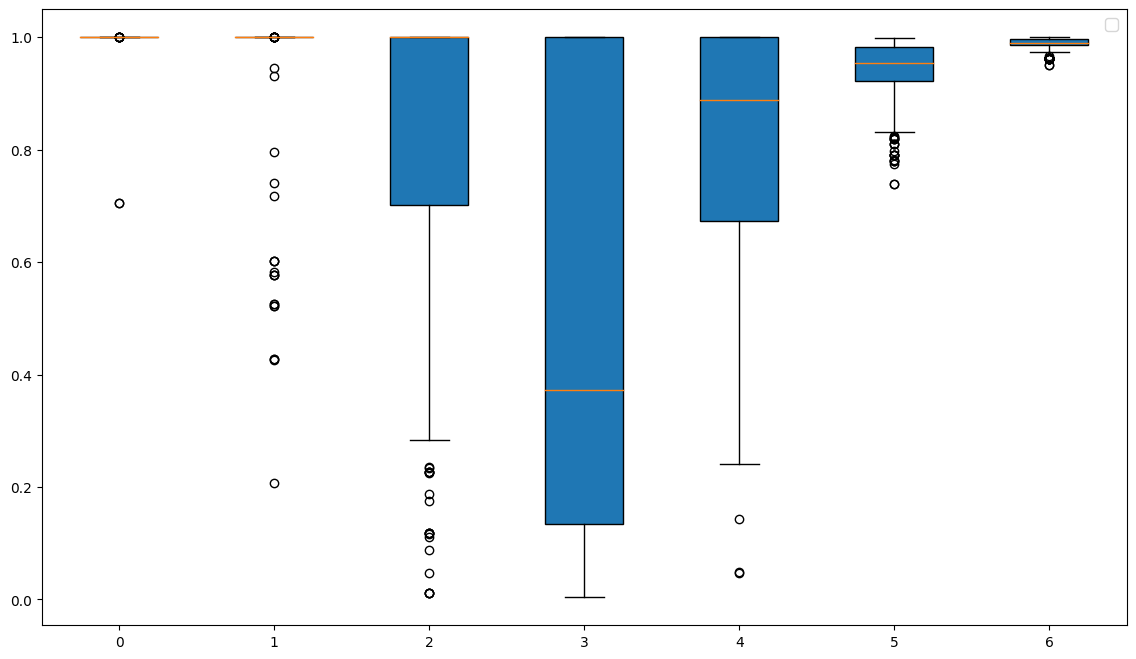

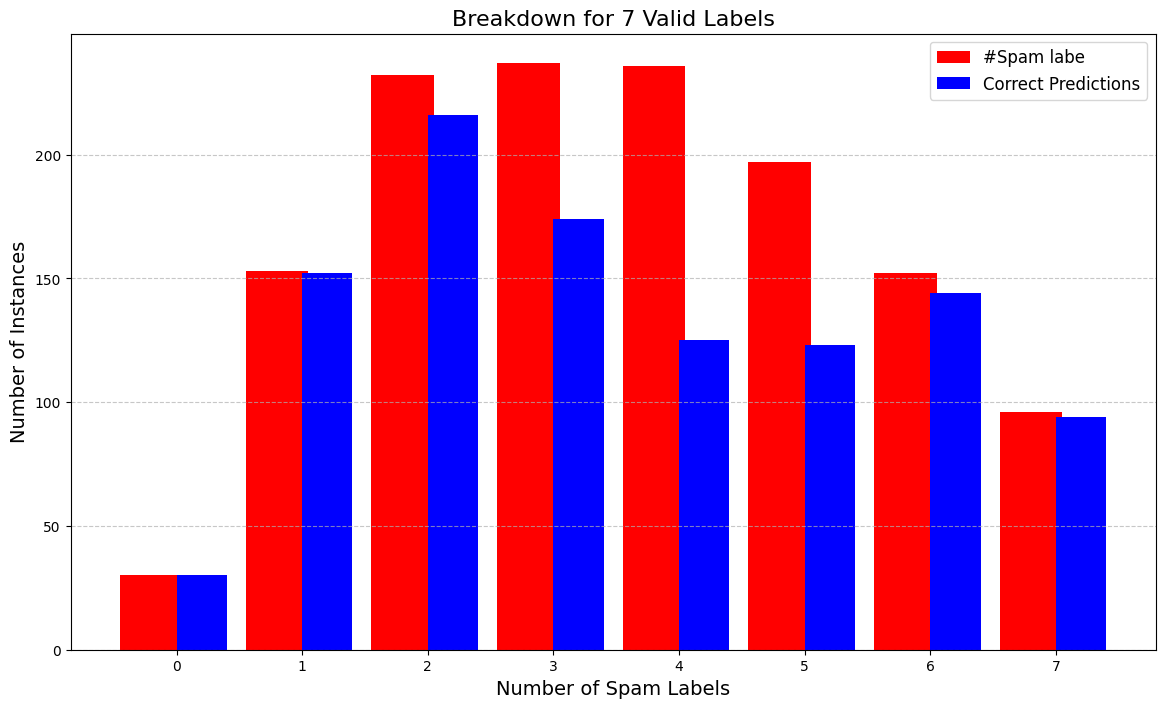

WARNING 2024-08-19 04:47:21,570 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


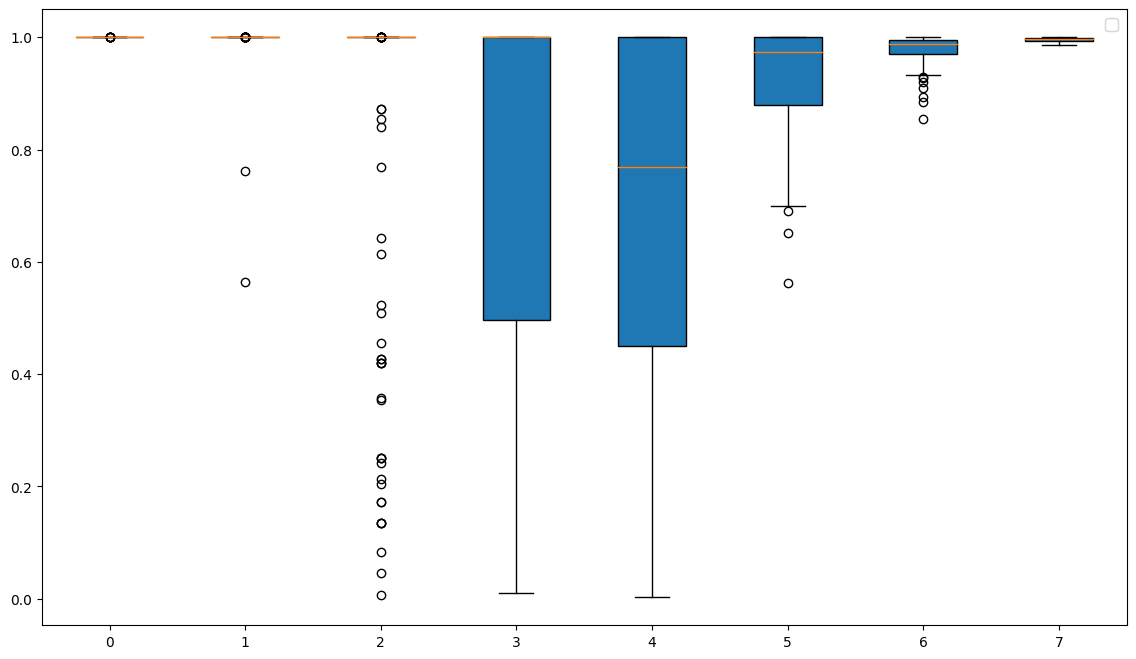

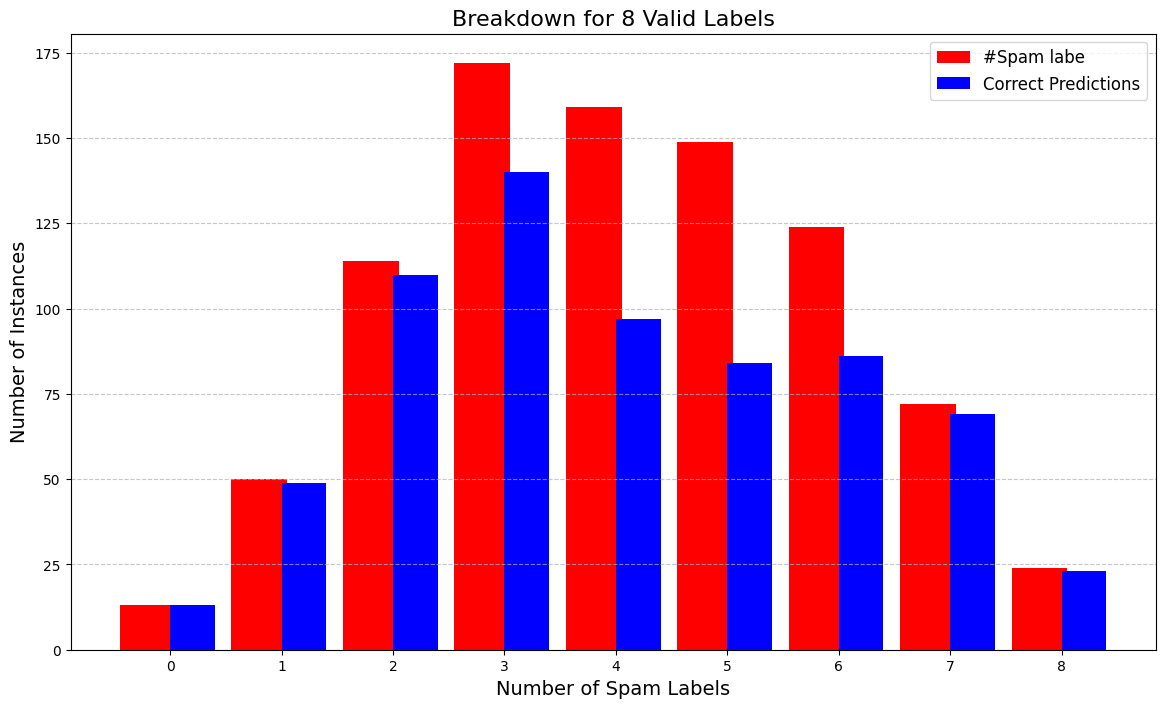

WARNING 2024-08-19 04:47:22,347 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


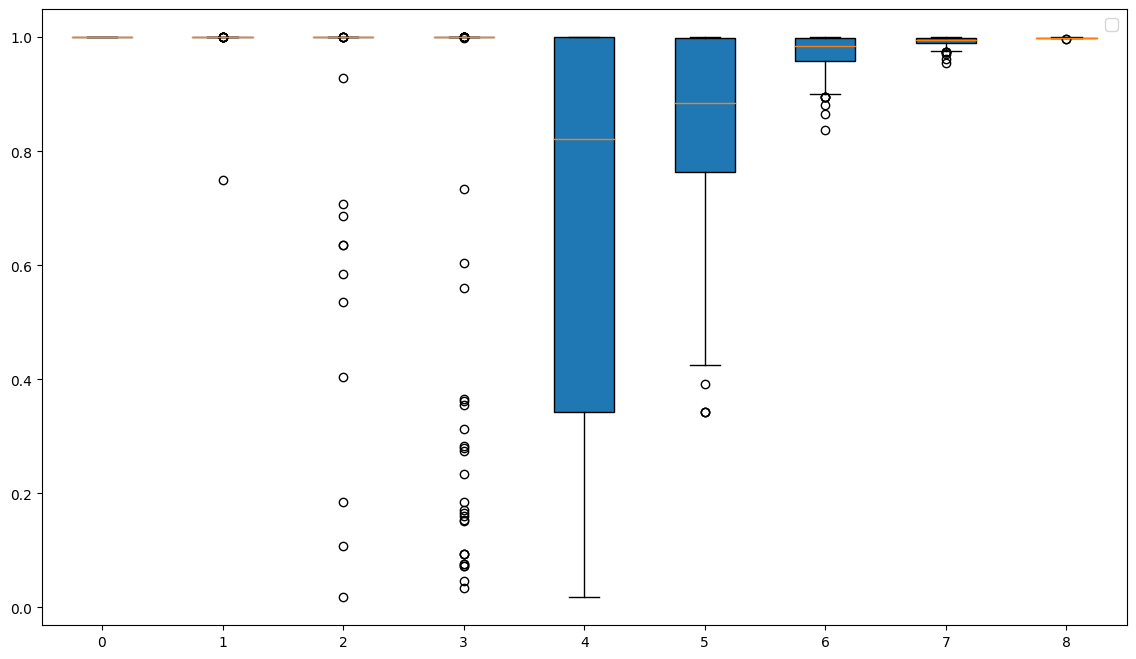

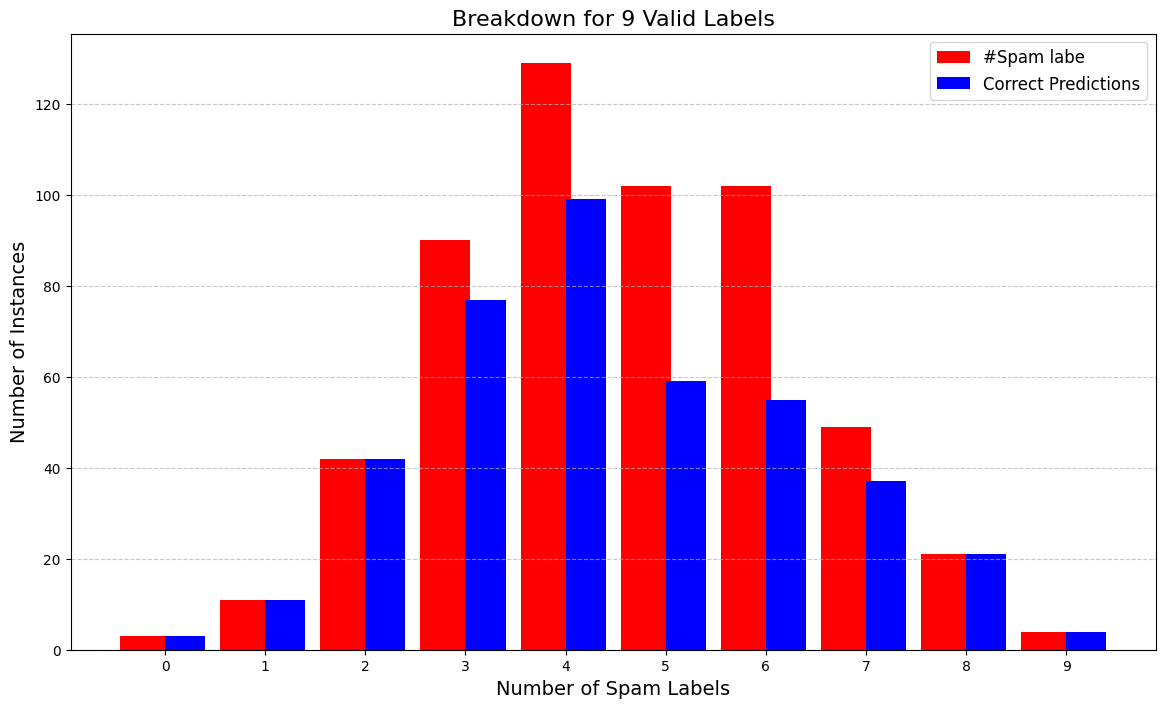

WARNING 2024-08-19 04:47:22,795 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


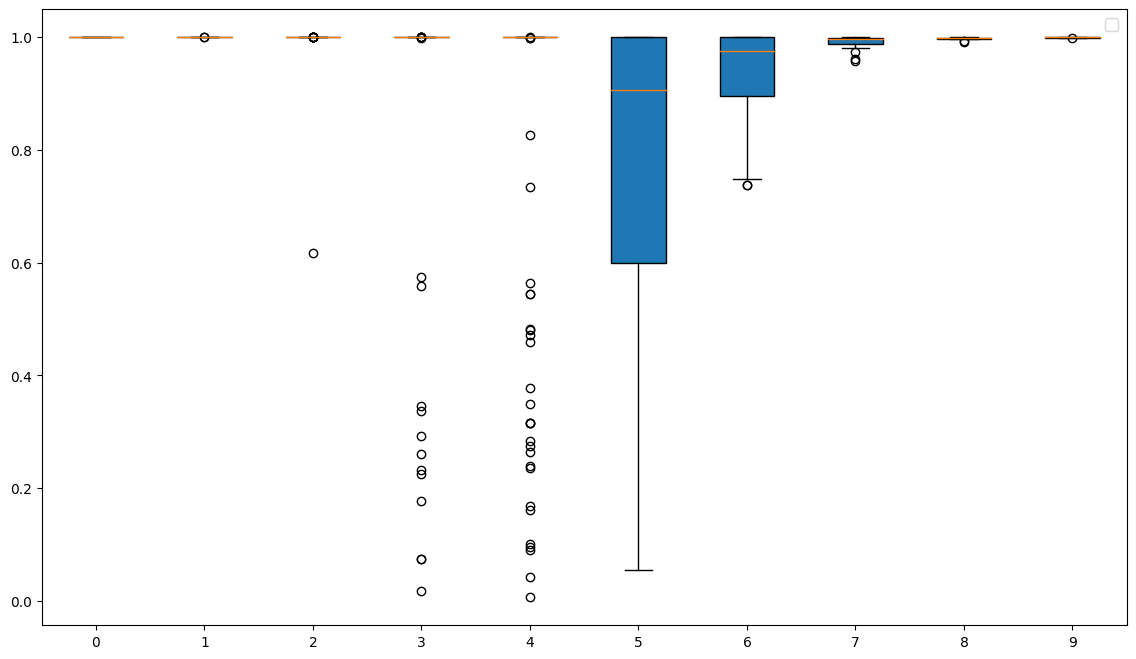

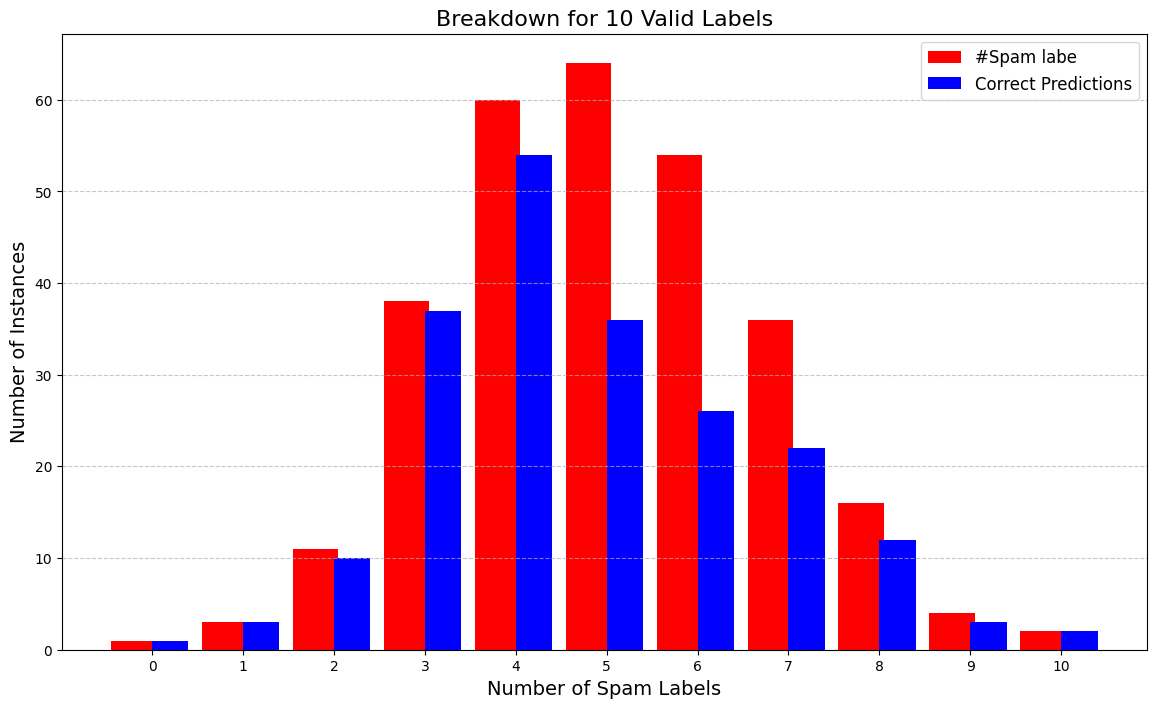

WARNING 2024-08-19 04:47:23,257 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


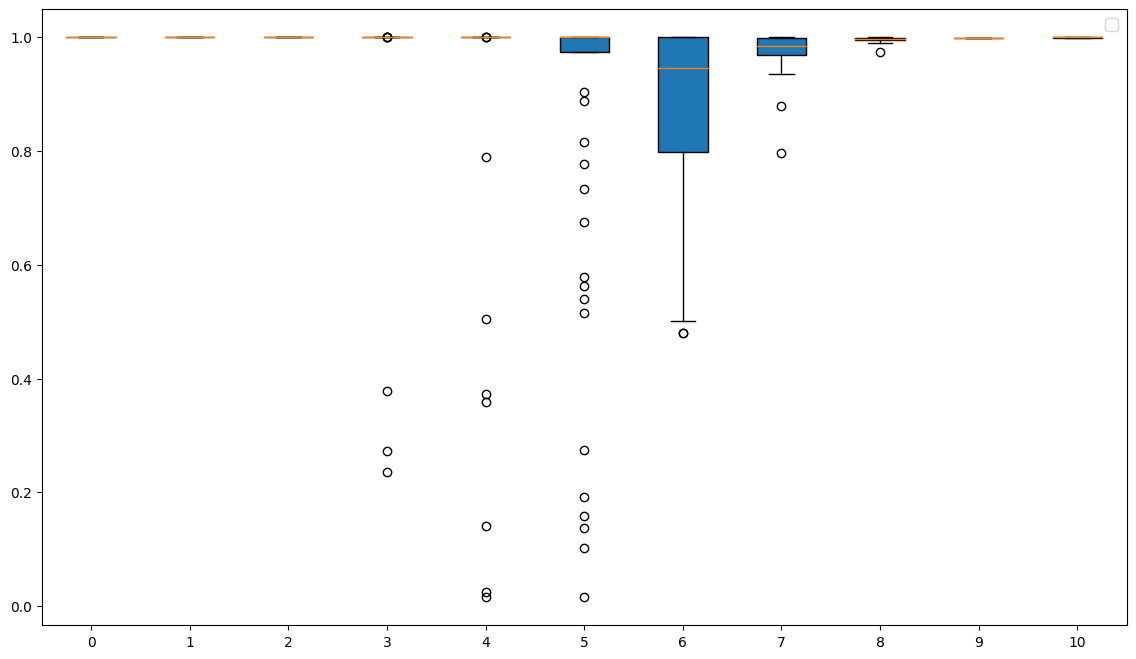

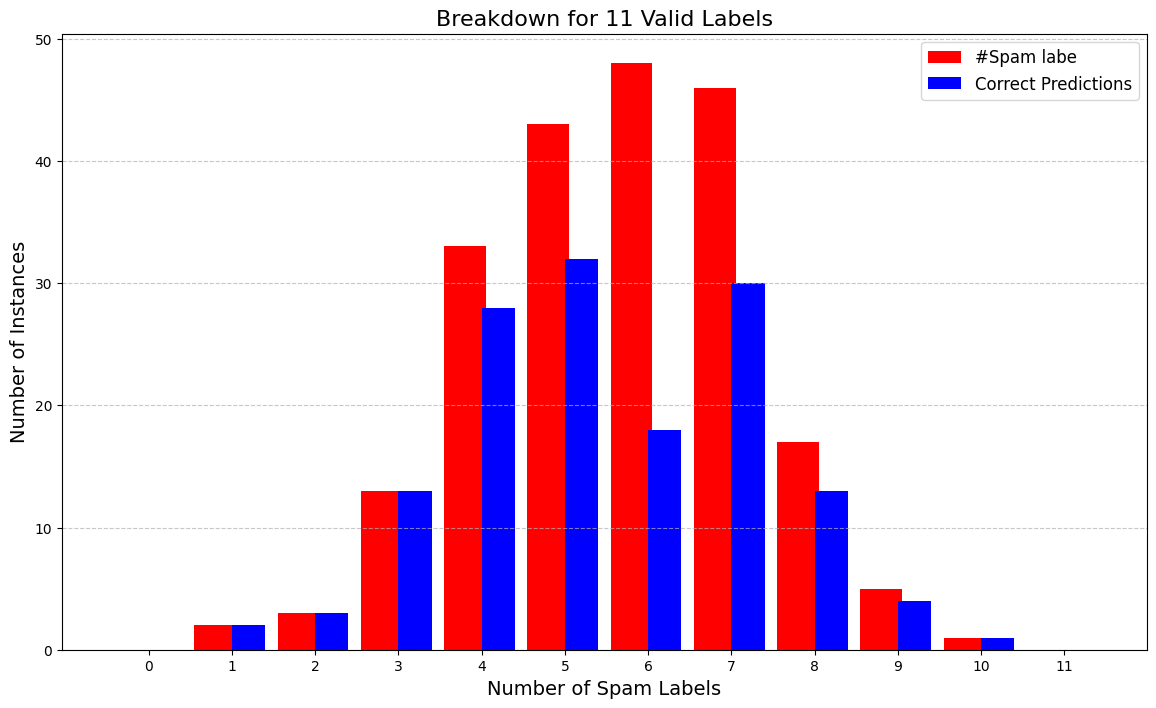

WARNING 2024-08-19 04:47:23,732 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


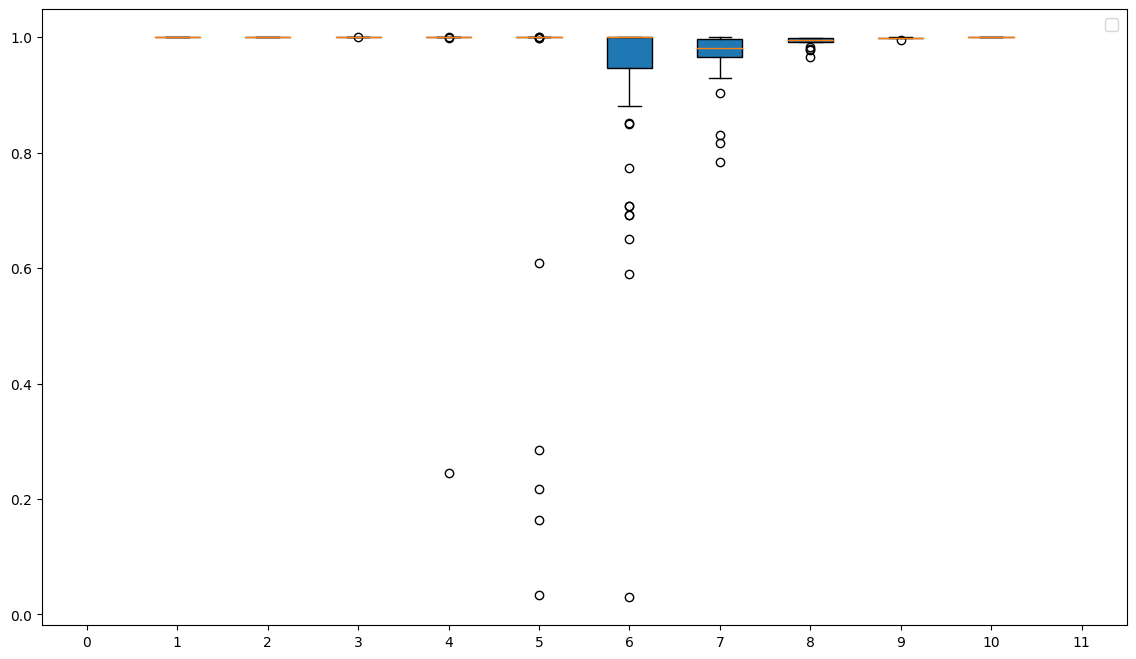

In [83]:
for i in range(1,12):
    drill_down_dist(lf_vectors=lf_vectors, chosen_valid_labels=i, snorkel_probs=snorkel_probs, snorkel_preds=snorkel_predictions)

1. decide if a lf is already good enough? (avoid overfitting)
2. only do partition only when its obvious, otherwise we fall to be conservative, keep the flavor, only decrease    coverage
3. new stopping point, dont exahustively repair
4. create lf from scratch
5. keep a list of general factors that affect the performance of the model, and "tune" them on a validation set to get a preferable repair types based on those results. 
6. refinement consider stats from whole dataset? (e.g. coverage over whole dataset)